In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torchaudio import transforms
from scipy.signal import coherence, welch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from torch.fft import ifft, fftfreq
from pytorch_lightning.callbacks import EarlyStopping
import scipy

In [2]:
def qpsk_augmentation(x, sample_rate=120, carrying_freq=12):
    x = x.clone()
    device = x.device
    t = torch.linspace(0, x.shape[0]/sample_rate, x.shape[0], device=device)
    
    # 1. Базовый белый шум (всегда присутствует)
    noise_level = 0.01 + torch.rand(1).item() * 0.05
    x += torch.randn_like(x) * noise_level
    
    # Выбираем ОДИН основной тип интерференции
    interference_type = torch.randint(0, 4, (1,)).item()
    
    if interference_type == 0 or 1:
        # 2. Низкочастотные помехи (от приборов)
        freq = carrying_freq * (0.1 + torch.rand(1).item()*0.4)  # 10-50% от несущей
        amplitude = 0.1 + torch.rand(1).item() * 0.3
        interference = amplitude * torch.sin(2 * np.pi * freq * t)
        x += interference
    
    elif interference_type == 1 or 2:
        # 3. Узкополосные помехи (соседние каналы)
        freq = carrying_freq + (torch.randn(1).item() * 0.2 * carrying_freq)
        bandwidth = sample_rate * (0.01 + torch.rand(1).item()*0.05)
        interference = 0.2 * torch.sin(2 * np.pi * freq * t) * \
                     torch.exp(-(t-0.5*t[-1])**2/(2*(bandwidth**2)))
        x += interference
    
    elif interference_type == 2 or 3:
        # 4. Импульсные помехи (переключения оборудования)
        n_impulses = torch.randint(1, 5, (1,)).item()
        for _ in range(n_impulses):
            pos = torch.randint(0, x.shape[0], (1,))
            length = torch.randint(5, 20, (1,))
            impulse = (0.3 + torch.rand(1).item()*0.7) * \
                     torch.sin(2*np.pi*carrying_freq*t[pos:pos+length])
            x[pos:pos+length] += impulse
    
    elif interference_type == 3 or 0:
        # 5. Гармоники от импульсных источников питания
        base_freq = 50 + torch.randn(1).item() * 10  # 50Гц ± вариации
        for harmonic in range(1, 6):
            if torch.rand(1).item() > 0.7:
                continue
            freq = base_freq * harmonic
            amplitude = 0.05 / harmonic + torch.rand(1).item()*0.1
            phase = torch.rand(1).item() * 2 * np.pi
            x += amplitude * torch.sin(2 * np.pi * freq * t + phase)
    
    # 6. Нелинейные искажения (умеренные)
    if torch.rand(1).item() < 0.5:
        distortion = 0.05 + torch.rand(1).item() * 0.1
        x = x + distortion * torch.tanh(x / (distortion + 1e-8))
    
    return x

In [3]:
class QPSKDataset(Dataset):
    def __init__(self, num_samples, time, symbol_rate, sample_rate, carrying_freq, augment_fn):
        self.num_samples = num_samples
        self.time = time
        self.symbol_rate = symbol_rate
        self.sample_rate = sample_rate
        self.carrying_freq = carrying_freq
        self.augment_fn = augment_fn
        self.samples_per_symbol = int(sample_rate / symbol_rate)

    def __len__(self):
        return self.num_samples

    def generate_qpsk(self):
        num_symbols = int(self.time * self.symbol_rate)
        num_samples = int(self.time * self.sample_rate)
        samples_per_symbol = int(self.sample_rate / self.symbol_rate)

        bits = np.random.randint(0, 2, size=num_symbols * 2)
        symbols = bits.reshape(-1, 2)

        phase_map = {
            (0, 0): (1, 0),    # 0° (I=1, Q=0)
            (0, 1): (0, 1),     # 90° (I=0, Q=1)
            (1, 1): (-1, 0),    # 180° (I=-1, Q=0)
            (1, 0): (0, -1)     # 270° (I=0, Q=-1)
        }

        iq = np.array([phase_map[tuple(b)] for b in symbols])
        i_vals, q_vals = iq[:, 0], iq[:, 1]

        i_samples = np.repeat(i_vals, samples_per_symbol)
        q_samples = np.repeat(q_vals, samples_per_symbol)

        t = np.linspace(0, self.time, int(self.time * self.sample_rate), endpoint=False)

        carrier_cos = np.cos(2 * np.pi * self.carrying_freq * t) * (np.sqrt(2)/2)
        carrier_sin = np.sin(2 * np.pi * self.carrying_freq * t) * (np.sqrt(2)/2)

        signal = i_samples * carrier_cos - q_samples * carrier_sin
        iq_signal = np.stack([i_samples*carrier_cos, q_samples*carrier_sin], axis=0)  # Shape: [2, T]
        return signal.astype(np.float32)

    def __getitem__(self, idx):
        clean = self.generate_qpsk()  # Должен возвращать [seq_len]
        if clean.shape[-1] % 2 != 0:
            clean = clean[..., :-1]  # убираем 1 с конца
        noisy = self.augment_fn(torch.tensor(clean.copy())) if self.augment_fn else clean
        return noisy, clean  # Оба [seq_len]




In [4]:

class QPSKDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, num_workers=0, **signal_params):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.signal_params = signal_params
        self.samples_per_symbol = int(signal_params["sample_rate"] / signal_params["symbol_rate"])

    def setup(self, stage=None):
        self.train_dataset = QPSKDataset(
            num_samples=10000,
            augment_fn=qpsk_augmentation,
            **self.signal_params
        )
        self.val_dataset = QPSKDataset(
            num_samples=1000,
            augment_fn=None,
            **self.signal_params
        )

        self.test_dataset =QPSKDataset(
            num_samples=1000,
            augment_fn=qpsk_augmentation,
            **self.signal_params
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers
        )


    def get_samples_per_symbol(self):
        return self.samples_per_symbol

In [5]:
def hilbert_torch(x):
    """Гильбертово преобразование для получения аналитического сигнала."""
    Xf = torch.fft.fft(x, dim=-1)
    N = x.shape[-1]

    h = torch.zeros(N, dtype=torch.cfloat, device=x.device)
    if N % 2 == 0:
        h[0] = 1
        h[1:N//2] = 2
        h[N//2] = 1
    else:
        h[0] = 1
        h[1:(N+1)//2] = 2

    return torch.fft.ifft(Xf * h, dim=-1)

def phase_loss_qpsk(denoised, clean, weight_smoothness=0.1):
    """
    :param denoised: восстановленный сигнал (batch, time)
    :param clean: истинный сигнал (batch, time)
    :return: комбинированный loss: фазовая ошибка + плавность
    """
    # Получаем фазы через аналитические сигналы
    analytic_denoised = hilbert_torch(denoised)
    analytic_clean = hilbert_torch(clean)

    phase_denoised = torch.atan2(analytic_denoised.imag, analytic_denoised.real)
    phase_clean = torch.atan2(analytic_clean.imag, analytic_clean.real)

    # Фазовая ошибка по окружности (модуль 2π)
    phase_diff = torch.angle(torch.exp(1j * (phase_denoised - phase_clean)))
    phase_mse = torch.mean(phase_diff ** 2)

    # Smoothness: насколько сильно фаза скачет между соседними отсчётами
    delta_phase = torch.angle(torch.exp(1j * (phase_denoised[:, 1:] - phase_denoised[:, :-1])))
    smoothness = torch.mean(delta_phase ** 2)

    total_loss = phase_mse + weight_smoothness * smoothness
    return total_loss


In [6]:
class DNN_PNC(nn.Module):
    def __init__(self, input_channels=1, num_filters=64):
        super(DNN_PNC, self).__init__()
        
        # Энкодер
        self.encoder1 = self._block(input_channels, num_filters)
        self.encoder2 = self._block(num_filters, num_filters*2)
        self.encoder3 = self._block(num_filters*2, num_filters*4)
        self.encoder4 = self._block(num_filters*4, num_filters*8)
        
        # Боттлнек
        self.bottleneck = self._block(num_filters*8, num_filters*16)
        
        # Декодер
        self.decoder1 = self._block(num_filters*16 + num_filters*8, num_filters*8)  # + skip connections
        self.decoder2 = self._block(num_filters*8 + num_filters*4, num_filters*4)
        self.decoder3 = self._block(num_filters*4 + num_filters*2, num_filters*2)
        self.decoder4 = self._block(num_filters*2 + num_filters, num_filters)
        
        # Выходной слой
        self.out_conv = nn.Conv1d(num_filters, input_channels, kernel_size=1)
        
        # Пулинг и апсемплинг
        self.pool = nn.MaxPool1d(2)
        self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Добавляем dimension канала если нужно
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [batch, 1, seq_len]

        
            
        # Энкодер
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        # Боттлнек
        bottleneck = self.bottleneck(self.pool(enc4))
        


        # Декодер с skip-connections
        dec1 = self.up(bottleneck)
        
        dec1 = torch.cat([dec1, enc4], dim=1)
        dec1 = self.decoder1(dec1)
        
        dec2 = self.up(dec1)
        dec2 = torch.cat([dec2, enc3], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec3 = self.up(dec2)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec4 = self.up(dec3)
        dec4 = torch.cat([dec4, enc1], dim=1)
        dec4 = self.decoder4(dec4)
        
        return self.out_conv(dec4)

In [7]:
class QPSKDenoiser(pl.LightningModule):
    def __init__(self, model, lr=1e-3, phase_loss_smoothness=1):
        super().__init__()
        self.model = model
        self.lr = lr
        
        self.phase_loss_smoothness = phase_loss_smoothness
        self.mse_loss = nn.MSELoss()
        self.cos_dist = nn.CosineSimilarity()
        

    def forward(self, x):
        # Добавляем dimension канала если нужно
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [batch, 1, seq_len]


        return self.model(x)
    
        

    
    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        predicted_noise = self(noisy)
        denoised = noisy - predicted_noise.squeeze(1)  # Убираем dimension канала для сравнения
        mse_loss =  self.mse_loss(denoised,clean)
        phase_loss = phase_loss_qpsk(denoised, clean, weight_smoothness=self.phase_loss_smoothness)
        cos_distance = 1 - self.cos_dist(denoised, clean).mean()
        total_loss = 0*mse_loss + 0 * phase_loss + cos_distance
        self.log("train_mseloss", mse_loss)
        self.log("train_phaseloss", phase_loss)
        self.log("train_loss", total_loss)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        predicted_noise = self(noisy)
        denoised = noisy - predicted_noise.squeeze(1)
        mse_loss = self.mse_loss(denoised, clean)
        phase_loss = phase_loss_qpsk(denoised, clean, weight_smoothness=self.phase_loss_smoothness)
        self.log("val_mseloss", mse_loss)
        self.log("val_phaseloss", phase_loss)
        total_valloss = mse_loss + phase_loss
        self.log("val_loss", total_valloss)
        return total_valloss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [8]:
# Параметры сигнала
signal_params = {
    "time": 2,           # длительность сигнала в секундах
    "symbol_rate": 6,   # скорость символов (бод)
    "sample_rate": 120 ,  # частота дискретизации
    "carrying_freq": 12.0  # несущая частота
}

model = DNN_PNC(input_channels=1)
datamodule = QPSKDataModule(batch_size=32, **signal_params)

# Проверка размерностей
datamodule.setup()
sample = next(iter(datamodule.train_dataloader()))
print(f"Размерность батча: {sample[0].shape}")  # Должно быть [32, seq_len]


Размерность батча: torch.Size([32, 240])


In [9]:
early_stop = EarlyStopping('val_loss', patience = 3, mode='min', verbose=True)

In [10]:
logger = TensorBoardLogger("tb_logs", name="qpsk_denoiserwithunet")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    logger=logger,
    devices=1 if torch.cuda.is_available() else None,
    callbacks= [early_stop]
)

denoiser = QPSKDenoiser(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(denoiser, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | model    | DNN_PNC          | 10.5 M | train
1 | mse_loss | MSELoss          | 0      | train
2 | cos_dist | CosineSimilarity | 0      | train
------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.900    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.575


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.575. Signaling Trainer to stop.


In [12]:
#model = QPSKDenoiser.load_from_checkpoint('tb_logs\qpsk_denoiserwithunet\version_0\checkpoints\epoch=12-step=4056.ckpt')

In [13]:
def denoise_signal(model, datamodule, num_examples = 5):
    test_loader = datamodule.test_dataloader()
    
    results = []
    with torch.no_grad():
        # Берем несколько батчей из тестового набора
        for batch_idx, (noisy, clean) in enumerate(test_loader):
            if batch_idx >= num_examples:
                break
                
            # Применяем модель
            predicted_noise = model(noisy)
            denoised = noisy - predicted_noise.squeeze(1)
            
            # Конвертируем в numpy и сохраняем
            for i in range(noisy.size(0)):
                results.append((
                    noisy[i].numpy(),      # Зашумленный сигнал
                    denoised[i].numpy(),   # Очищенный сигнал
                    clean[i].numpy()       # Исходный чистый сигнал
                ))
                
    return results

In [14]:
results = denoise_signal(model, datamodule)

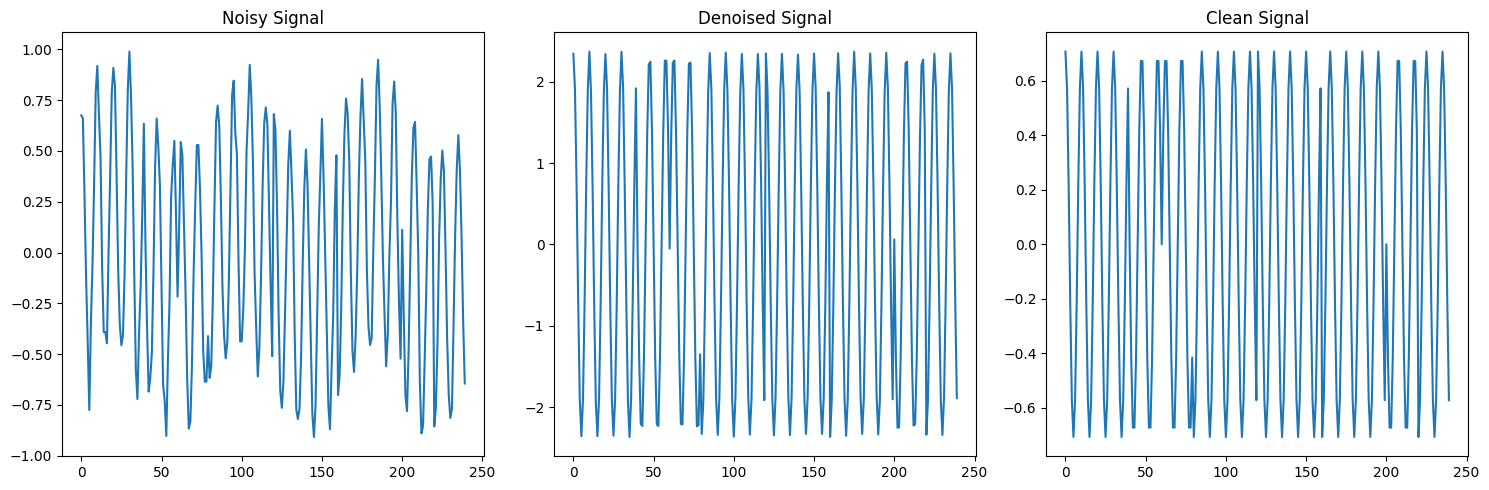

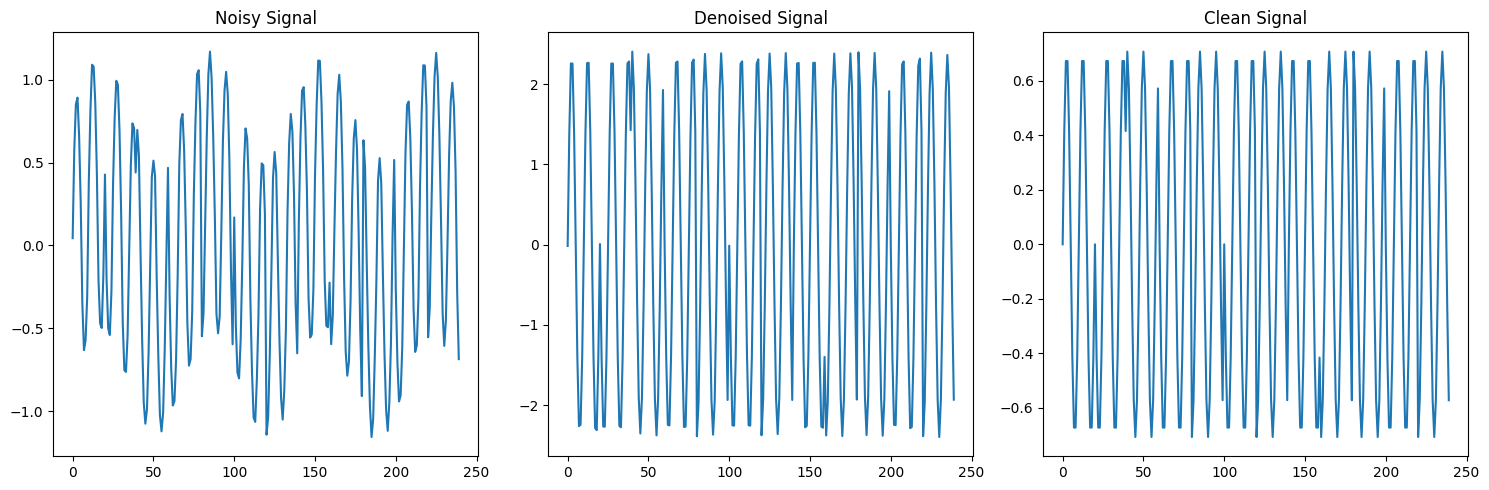

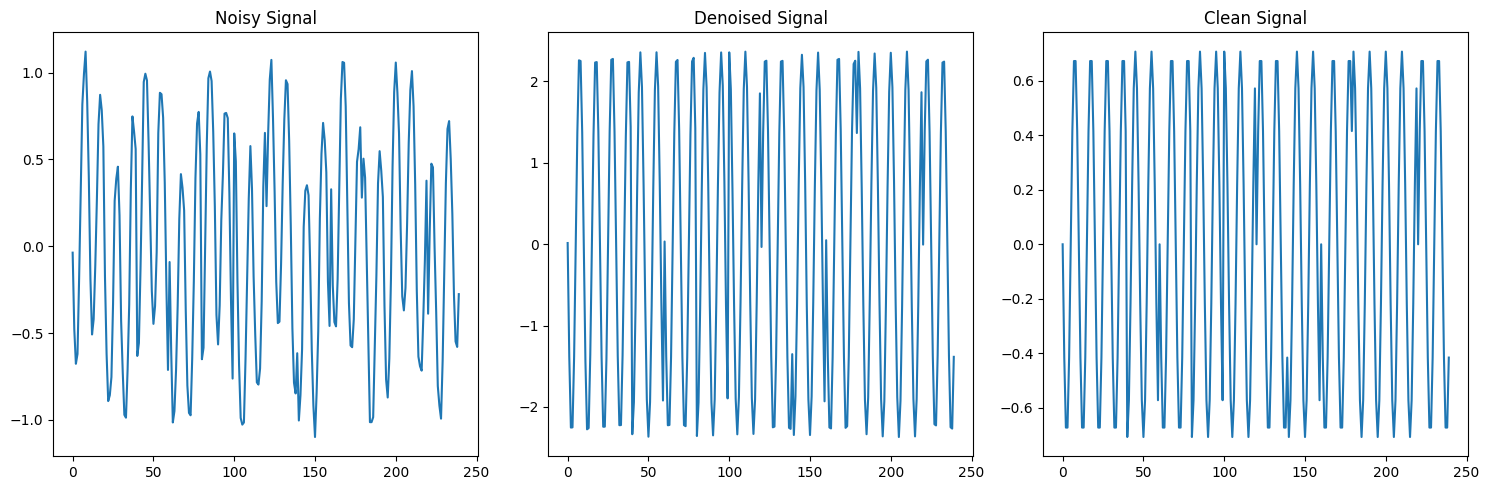

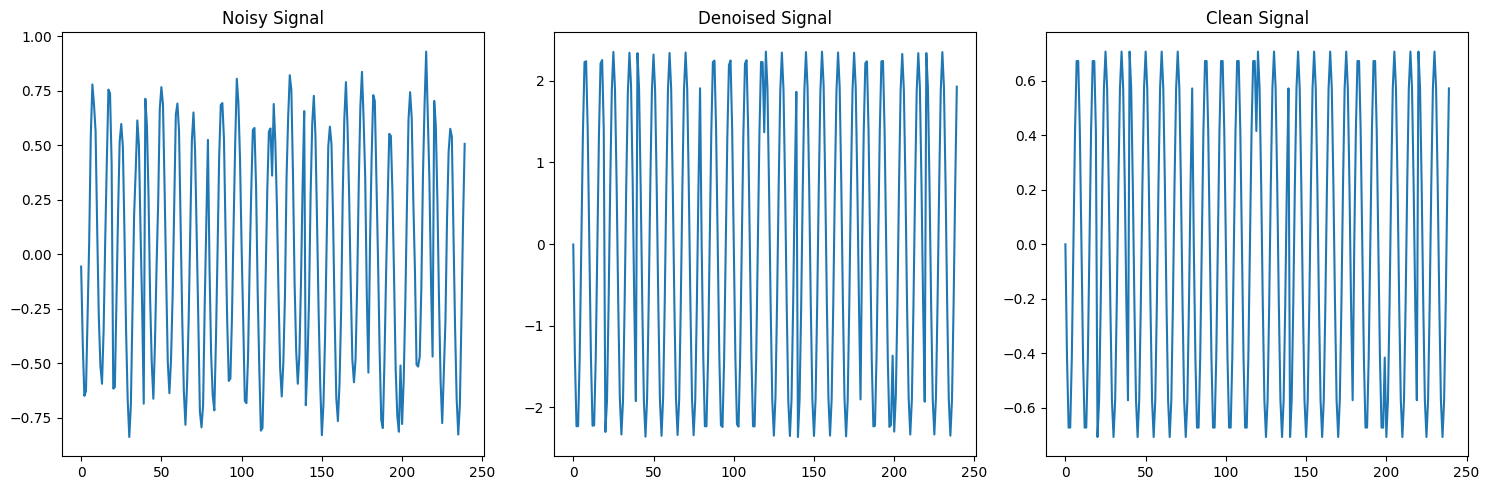

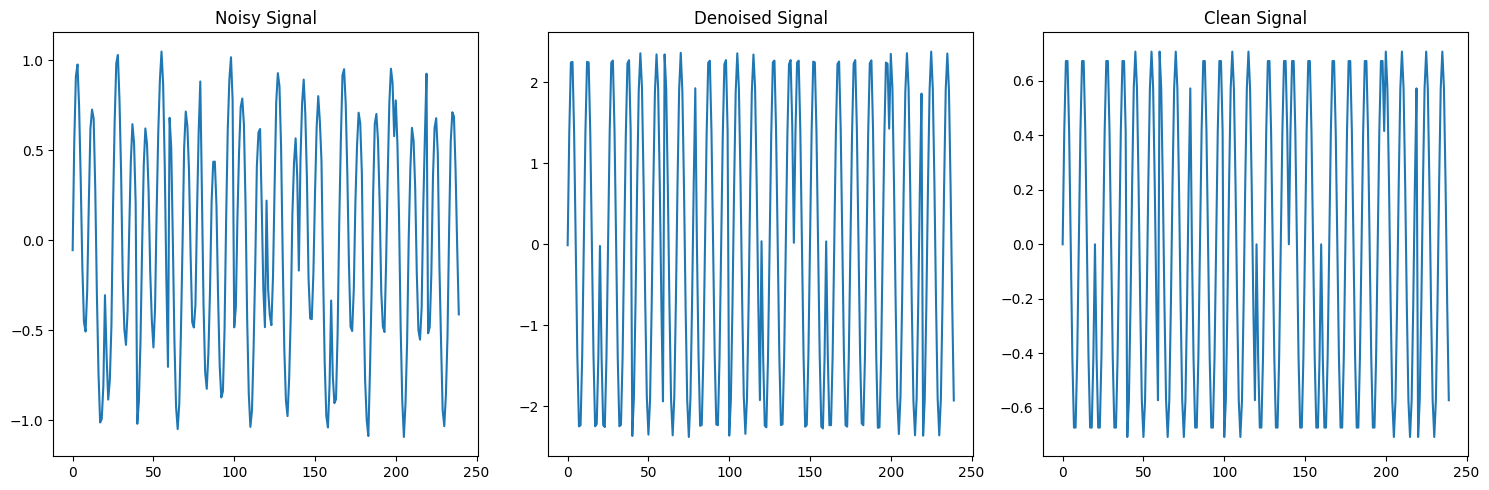

In [15]:
for noisy, denoised, clean in results[:5]:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Noisy Signal")
    plt.plot(noisy)
    plt.subplot(1, 3, 2)
    plt.title("Denoised Signal")
    plt.plot(denoised)
    plt.subplot(1, 3, 3)
    plt.title("Clean Signal")
    plt.plot(clean)
    plt.tight_layout()
    plt.show()

In [16]:
class SignalMetrics:
    def __init__(self, sample_rate=120, carrying_freq=12, symol_rate = 6):
        self.sample_rate = sample_rate
        self.carrying_freq = carrying_freq
        self.symbol_rate = symol_rate
        


    def calculate_all(self, clean, denoised):
        return {
            'SNR': self.snr_db(clean, denoised),
            'SDR': self.sdr(clean, denoised),
            'MSE': mean_squared_error(clean, denoised),
            'Coherence': self.coherence(clean, denoised),
            'Spectral_Loss': self.spectral_loss(clean, denoised),
            'Phase_Diff': self.phase_difference(clean, denoised)
        }
    
    def snr_db(self, clean, denoised):
        noise = clean - denoised
        power_signal = np.mean(clean**2)
        power_noise = np.mean(noise**2)
        return 10 * np.log10(power_signal / (power_noise + 1e-12))
    
    def sdr(self, clean, denoised):
        """Source-to-Distortion Ratio"""
        return 10 * np.log10(np.sum(clean**2) / (np.sum((clean - denoised)**2) + 1e-12))
    
    def coherence(self, clean, denoised, nperseg=None):
        if nperseg is None:
            nperseg = min(256, len(clean) // 2)
            
        f, coh = coherence(clean, denoised, fs=self.sample_rate, nperseg=nperseg)
        
        # Берем полосу ±3 символа вокруг несущей
        bandwidth = 3 * (self.symbol_rate if self.symbol_rate else self.sample_rate/10)
        freq_mask = (f > max(0, self.carrying_freq - bandwidth)) & \
                    (f < min(self.sample_rate/2, self.carrying_freq + bandwidth))
        
        return np.mean(coh[freq_mask])
    
    def spectral_loss(self, clean, denoised, nperseg=None):
        if nperseg is None:
            nperseg = min(256, len(clean) // 2)
            
        f, P_clean = welch(clean, fs=self.sample_rate, nperseg=nperseg)
        f, P_denoised = welch(denoised, fs=self.sample_rate, nperseg=nperseg)
        
        # Берем более широкую полосу для spectral loss
        bandwidth = 5 * (self.symbol_rate if self.symbol_rate else self.sample_rate/8)
        freq_mask = (f > max(0, self.carrying_freq - bandwidth)) & \
                    (f < min(self.sample_rate/2, self.carrying_freq + bandwidth))
        
        return np.mean(np.abs(P_clean - P_denoised)[freq_mask])
    
    def phase_difference(self, clean, denoised):
        analytic_clean = clean + 1j * np.imag(scipy.signal.hilbert(clean))
        analytic_denoised = denoised + 1j * np.imag(scipy.signal.hilbert(denoised))
        phase_diff = np.angle(analytic_clean * np.conj(analytic_denoised))
        return np.std(phase_diff)
    
    
    

In [17]:
metrics = SignalMetrics()

In [18]:
metric_list = []

for i in range(5):
   metric_list.append( metrics.calculate_all(results[i][2], results[i][1]))

In [19]:
metric_list

[{'SNR': -7.288532458227447,
  'SDR': -7.288532509775548,
  'MSE': 1.3390391,
  'Coherence': 0.9994423,
  'Spectral_Loss': 0.05999509,
  'Phase_Diff': 0.054555204},
 {'SNR': -7.486982280810254,
  'SDR': -7.48698228080717,
  'MSE': 1.4016457,
  'Coherence': 0.9995518,
  'Spectral_Loss': 0.062169243,
  'Phase_Diff': 0.014748769},
 {'SNR': -7.359255536721079,
  'SDR': -7.359255612795859,
  'MSE': 1.3610233,
  'Coherence': 0.9992432,
  'Spectral_Loss': 0.060910992,
  'Phase_Diff': 0.027102994},
 {'SNR': -7.290011085330745,
  'SDR': -7.290011162628192,
  'MSE': 1.3394951,
  'Coherence': 0.99944514,
  'Spectral_Loss': 0.0603963,
  'Phase_Diff': 0.01083408},
 {'SNR': -7.368803088523084,
  'SDR': -7.368802936698129,
  'MSE': 1.3640187,
  'Coherence': 0.99821013,
  'Spectral_Loss': 0.061064225,
  'Phase_Diff': 0.06559565}]